# ML Technique - SVM

Sources: https://github.com/cmadusankahw/email-spam-detection-with-SVM

https://www.kaggle.com/code/elnahas/phishing-email-detection-using-svm-rfc

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
directory = '/content/drive/MyDrive/career'
os.chdir(directory)

Mounted at /content/drive


In [4]:
import pandas as pd

# UVIC Dataset
file_path = '/content/drive/MyDrive/career/CaptstoneProjectData_2024.csv'
uvicData = pd.read_csv(file_path)

# Remove unnecessary columns
uvicData_cleaned = uvicData.drop(columns=['Unnamed: 2', 'Unnamed: 3'], errors='ignore')

# Replace empty 'Subject' with space
uvicData_cleaned['Subject'] = uvicData_cleaned['Subject'].fillna(' ')

# Check and remove rows with missing 'Body'
data_cleaned = uvicData_cleaned.dropna(subset=['Body'])

# Normalize text: convert to lowercase, remove special characters, and trim whitespaces
uvicData_cleaned['Subject'] = uvicData_cleaned['Subject'].str.lower().str.replace('[^\w\s]', '', regex=True).str.strip()
uvicData_cleaned['Body'] = uvicData_cleaned['Body'].str.lower().str.replace('[^\w\s]', '', regex=True).str.strip()

# Confirm cleaning
print(uvicData_cleaned.head())

                                             Subject  \
0  review your shipment details  shipment notific...   
1                            υоur ассоunt іѕ оn hоld   
2  completed invoice  kz89tys2564 frombestbuycom ...   
3                              uvic important notice   
4             you have 6 suspended incoming messages   

                                                Body  
0  notice this message was sent from outside the ...  
1  votre réponse a bien été prise en compte\r\nht...  
2  notice this message was sent from outside the ...  
3  your uvic account has been filed under the lis...  
4  message generated from  uvicca source\r\n\r\n\...  


In [5]:
# Load the normal emails dataset
file_path = 'emails.csv'

normData = pd.read_csv(file_path)
normData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


In [6]:
def parse_email(message):
    lines = message.split('\n')
    subject = next((line.split(": ", 1)[1] for line in lines if line.lower().startswith('subject: ')), "")
    body_start = next(i for i, line in enumerate(lines) if line.strip() == '') + 1
    body = "\n".join(lines[body_start:])
    return subject, body

# Apply the function to the 'message' column
normData[['Subject', 'Body']] = normData['message'].apply(lambda x: pd.Series(parse_email(x)))
normData.head()

,file,message,Subject,Body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Re:,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,Re: test,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,,"Randy,\n\n Can you send me a schedule of the s..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Re: Hello,Let's shoot for Tuesday at 11:45.


In [7]:
normData['Subject'] = normData['Subject'].fillna(' ')
normData = normData.dropna(subset=['Body'])
normData = normData.drop(columns=['file', 'message'], errors='ignore')
# Normalize text: convert to lowercase, remove special characters, and trim whitespaces
normData['Subject'] = normData['Subject'].str.lower().str.replace('[^\w\s]', '', regex=True).str.strip()
normData['Body'] = normData['Body'].str.lower().str.replace('[^\w\s]', '', regex=True).str.strip()

# Showing the updated DataFrame with subject and body columns
normData.head()

,Subject,Body
0,,here is our forecast
1,re,traveling to have a business meeting takes the...
2,re test,test successful way to go
3,,randy\n\n can you send me a schedule of the sa...
4,re hello,lets shoot for tuesday at 1145


In [8]:
uvicData_cleaned['label'] = 1
normData['label'] = 0

masterData = pd.concat([uvicData_cleaned, normData], ignore_index=True)
masterData.head()

,Subject,Body,label
0,review your shipment details shipment notific...,notice this message was sent from outside the ...,1
1,υоur ассоunt іѕ оn hоld,votre réponse a bien été prise en compte\r\nht...,1
2,completed invoice kz89tys2564 frombestbuycom ...,notice this message was sent from outside the ...,1
3,uvic important notice,your uvic account has been filed under the lis...,1
4,you have 6 suspended incoming messages,message generated from uvicca source\r\n\r\n\...,1


In [9]:
# Feature Engineering: Length of the email body

def add_body_length(df):

    df['Body_Length'] = df['Body'].apply(lambda x: len(x) if isinstance(x, str) else pd.NA)
    return df

masterData = add_body_length(masterData.copy())
masterData.head()

,Subject,Body,label,Body_Length
0,review your shipment details shipment notific...,notice this message was sent from outside the ...,1,890
1,υоur ассоunt іѕ оn hоld,votre réponse a bien été prise en compte\r\nht...,1,1235
2,completed invoice kz89tys2564 frombestbuycom ...,notice this message was sent from outside the ...,1,3024
3,uvic important notice,your uvic account has been filed under the lis...,1,528
4,you have 6 suspended incoming messages,message generated from uvicca source\r\n\r\n\...,1,1234


In [10]:
# save final csv
masterData.to_csv('masterData.csv', index=False)  # Change index=False if you want to keep the index


/content/drive/MyDrive/career/masterData.csv

In [2]:
!pip install scikit-learn


In [11]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Load the Dataset

In [12]:
import pandas as pd

# Load the dataset
data_path = 'masterData.csv'
master_data = pd.read_csv(data_path)

# Display the first few rows of the dataset
master_data.head()

,Subject,Body,label,Body_Length
0,review your shipment details shipment notific...,notice this message was sent from outside the ...,1,890.0
1,υоur ассоunt іѕ оn hоld,votre réponse a bien été prise en compte\r\nht...,1,1235.0
2,completed invoice kz89tys2564 frombestbuycom ...,notice this message was sent from outside the ...,1,3024.0
3,uvic important notice,your uvic account has been filed under the lis...,1,528.0
4,you have 6 suspended incoming messages,message generated from uvicca source\r\n\r\n\...,1,1234.0


In [13]:
# Check for missing values
missing_values = master_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Subject        19365
Body              68
label              0
Body_Length        5
dtype: int64


In [14]:
# Handle missing values
# Remove rows with empty 'Body'
master_data = master_data.dropna(subset=['Body'])

# Replace missing values in 'Subject' with a space
master_data['Subject'].fillna(' ', inplace=True)

# Fill missing values in 'Body_Length' with the mean
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
master_data['Body_Length'] = imputer.fit_transform(master_data[['Body_Length']])

<ipython-input-14-6d6f94139557>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_data['Subject'].fillna(' ', inplace=True)
<ipython-input-14-6d6f94139557>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_data['Body_Length'] = imputer.fit_transform(master_data[['Body_Length']])


In [15]:
# Encode the 'Body' column as it is a categorical variable
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

le_body = LabelEncoder()
le_subject = LabelEncoder()


In [16]:
master_data['Body'] = le_body.fit_transform(master_data['Body'].astype(str))
master_data['Subject'] = le_subject.fit_transform(master_data['Subject'].astype(str))

In [17]:
# Separate features (X) and target variable (y)
X = master_data.drop('label', axis=1)
y = master_data['label']

In [18]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [20]:
# Check the shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training set shape: (415927, 3)
Testing set shape: (103982, 3)
Training target shape: (415927,)
Testing target shape: (103982,)


## Training the SVM Model

Training with svm_classifier = SVC()

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the SVM classifier
svm_classifier = SVC()

# Train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9947587082379643
Confusion Matrix:
 [[103437      0]
 [   545      0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    103437
           1       0.00      0.00      0.00       545

    accuracy                           0.99    103982
   macro avg       0.50      0.50      0.50    103982
weighted avg       0.99      0.99      0.99    103982



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classification report indicates that your SVM model is performing very poorly on the minority class (label 1). The model has high accuracy, but this is misleading because it is almost entirely predicting the majority class (label 0). This is a common issue when dealing with imbalanced datasets.

In [22]:
class_distribution = master_data['label'].value_counts()
print("Class Distribution:\n", class_distribution)

Class Distribution:
 label
0    517355
1      2554
Name: count, dtype: int64


Trying with LinearSVC

In [23]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the Linear SVM classifier with class weights
svm_classifier = LinearSVC(class_weight='balanced')

# Train the Linear SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.622626993133427
Confusion Matrix:
 [[64446 38991]
 [  249   296]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.62      0.77    103437
           1       0.01      0.54      0.01       545

    accuracy                           0.62    103982
   macro avg       0.50      0.58      0.39    103982
weighted avg       0.99      0.62      0.76    103982



Class Distribution:
 label
0    517355
1      2554
Name: count, dtype: int64


In [24]:
pip install imbalanced-learn


In [25]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the Linear SVM classifier with class weights
svm_classifier = LinearSVC(class_weight='balanced')

# Train the Linear SVM classifier on the resampled training data
svm_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy: 0.5134638687465138
Confusion Matrix:
 [[53008 50429]
 [  162   383]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.51      0.68    103437
           1       0.01      0.70      0.01       545

    accuracy                           0.51    103982
   macro avg       0.50      0.61      0.35    103982
weighted avg       0.99      0.51      0.67    103982




The results show that while using SMOTE with Linear SVM slightly improved the recall for the minority class, the overall accuracy is still low, and the precision for the minority class remains very poor. This suggests that the model is still struggling with the class imbalance despite the oversampling.

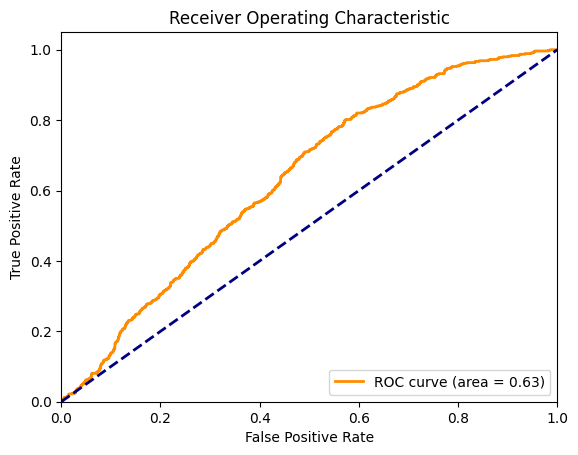

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
# Plot ROC curve
y_pred_prob = svm_classifier.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Next steps: Try Naive Bayes.
Naive Bayes: A good fit for text data and may handle imbalance better.

Accuracy: 0.5227058529360851
Confusion Matrix:
 [[54051 49386]
 [  244   301]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.52      0.69    103437
           1       0.01      0.55      0.01       545

    accuracy                           0.52    103982
   macro avg       0.50      0.54      0.35    103982
weighted avg       0.99      0.52      0.68    103982



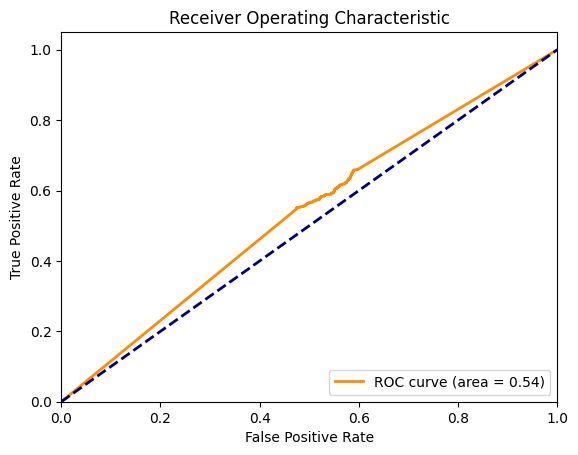

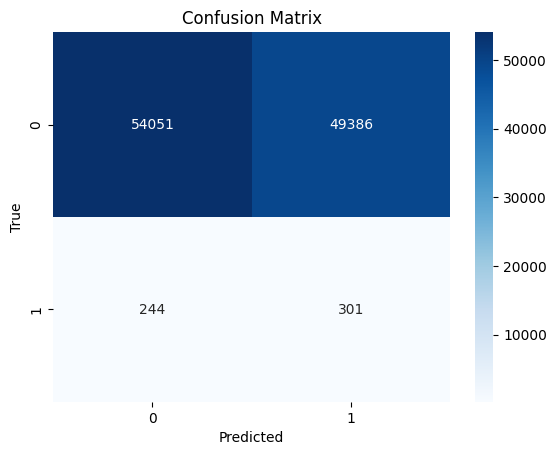

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Calculate ROC curve and AUC
y_pred_prob = nb_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
